In [21]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

seed = 12345678
rng = np.random.default_rng(seed)

# silence PyMC logging
import logging
logger = logging.getLogger("pymc")
logger.handlers.clear()

# Introduction


## The bias / variance tradeoff

The bias / variance tradeoff is a tentpole of statistical learning theory.  Here's [the wikipedia entry](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) if you need a refresher.  The gist of it is:

Adding more parameters to a model increases its ability to fit the training data set which decreasing the overall bias of the model's predictions.  Then, if you were to resample and refit the training set, the model's parameters will be more different each time, increasing the variance in that sense.  

The usual advice that follows is to use model selection techniques to try and find a balance between the complexity of your model and the fit on your training data set.  This blog post is about how to sidestep the model selection problem when we are in a Bayesian context by thinking carefully about our priors.   

## The subtle part

I had seen this quote in [Gelman's](https://statmodeling.stat.columbia.edu/2024/05/26/is-there-a-balance-to-be-struck-between-simple-hierarchical-models-and-more-complex-hierarchical-models-that-augment-the-simple-frameworks-with-more-modeled-interactions-when-analyzing-real-data/) [blog](https://statmodeling.stat.columbia.edu/2004/12/10/against_parsimo/) awhile back that reminded me of a cool example I saw years and years ago from [this short paper titled "Occam's razor"](https://mlg.eng.cam.ac.uk/zoubin/papers/occam.pdf) from NIPS 2000.  Andrew Gordon Wilson also demonstrates this with [a similar example in his thesis](https://www.cs.cmu.edu/%7Eandrewgw/andrewgwthesis.pdf).  
That paper showed that **fitting an unknown function using a large number of basis function with *particular* regularizing priors was preferable to casting the problem as model selection and choosing the optimal number of basis vectors.**  

The example in that paper made it click for me why non-parametric model components like Gaussian processes often work better than parametric models with a fixed set of features like polynomials or splines.  I also use this idea when I'm choosing which features -- actual features, not basis functions -- to consider adding into regression models.  So the quote, which is from [Radford Neal](https://glizen.com/radfordneal/bnn.book.html) in the context of Bayesian neural networks, is:

> Sometimes a simple model will outperform a more complex model . . . Nevertheless, I believe that deliberately limiting the complexity of the model is not fruitful when the problem is evidently complex. Instead, if a simple model is found that outperforms some particular complex model, the appropriate response is to define a different complex model that captures whatever aspect of the problem led to the simple model performing well.
 
The goal of this post is to illustrate this idea by reproducing the example in the "Occam's Razor" paper, but in a more modern software context using PyMC, sampling with NUTS, and finally using leave-one-out (LOO) crossvalidation for model selection.   

You've probably seen an example like this in textbooks:  Given a simple scatterplot, fit a curve to it and use model selection to determine the right number of basis functions to use.  You're usually choosing the best polynomial order.  The example is designed to demonstrate the [bias variance tradeoff](https://gursimar.github.io/d3-visualizations/bias-var/).  Or alternatively you can [use the Bayesian evidence](https://alumni.media.mit.edu/~tpminka/statlearn/demo/) to select the right polynomial degree.

I think what Neal is saying is that it's a mistake to transform the original problem into a new one, where the new goal is to find the "right" number of basis functions.  It's better to address the original problem directly, where the goal is to get a parsimonious representation of the unknown function.  Most likely no one will ever care about the best number of basis vectors to use.  By turning your modeling problem into a model selection problem, you've made your work harder.  

# Two experiments

We're going to run two experiments. First, and you've probably seen before, we're going to build a sequence of polynomial regression models with increasing complexity and then choose the "best" model, according to the leave-one-out crossvalidation (LOO-CV) metric.  We'll use the exact same priors for the polynomial coefficients.

Then in the second experiment, we'll do the exact same thing, **except, we'll keep decreasing the prior scale we use for the polynomial coefficients as we add more terms**.  Instead of the number of basis vectors, we're using our priors as the hedge against overfitting.  Then we'll see what LOO-CV says is the best model. 

We'll use data generated from a step function with a bit of additive Gaussian noise for our two experiments.  Notice that since we're using polynomial basis functions, none of our proposed models will be correct.  We're in the [M-open case](https://arxiv.org/pdf/1704.02030).  

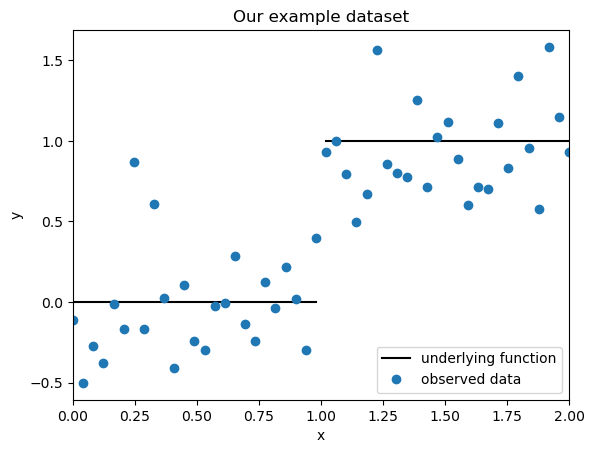

In [2]:
x = np.linspace(0, 2, 50)
f = np.ones(50)
f[:25] = 0.0
y = f + 0.3 * rng.normal(size=len(x))

plt.plot(x[:25], f[:25], color='k', label="underlying function")
plt.plot(x[25:], f[25:], color='k')
plt.plot(x, y, 'o', label="noisy observed data");
plt.xlim([0, 2]);
plt.xlabel("x");
plt.ylabel("y");
plt.legend(loc="lower right");
plt.title("Our example dataset");

## Details, details, details

Before getting going and actually modeling this there's one preliminary thing to mention.  Feel free to skip over this bit about the QR decomposition because it's not really core to the goal here.  We just need it to make our priors on the polynomial coefficients comparable and on the same overall scale.

We'll use the [QR decomposition](https://betanalpha.github.io/assets/case_studies/qr_regression.html) to orthogonalize our basis.  I found some [Python code to do this here](https://davmre.github.io/blog/python/2013/12/15/orthogonal_poly), pasted below.  

In [3]:
def ortho_poly_fit(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.vander(x, n, increasing=True)
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

The left panel below shows the first four polynomial basis vectors and gives their correlation matrix.  The right panel shows the same four basis vectors after they've been orthogonalized.  

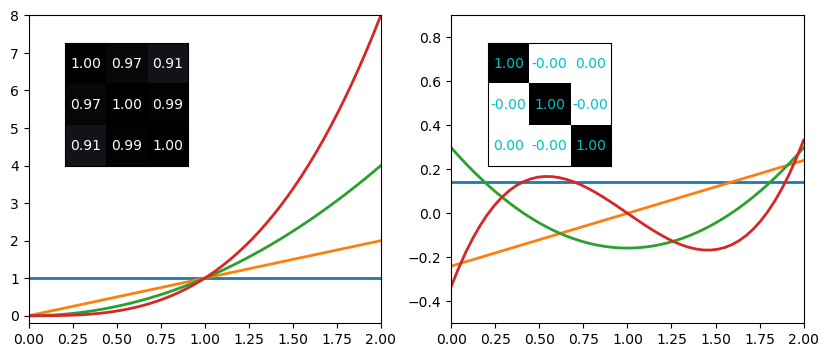

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

degree = 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10.0, 4.0])

## SUBPLOT 1
X = np.vander(x, degree + 1, increasing=True)[:, :degree+1]
ax1.plot(x, X, lw=2);
ax1.set_xlim([0.0, 2.0])
ax1.set_ylim([-0.2, 8.0])

axins1 = inset_axes(ax1, width="40%", height="40%", loc=2, borderpad=2)
Xcorr = np.corrcoef(X[:, 1:].T)
axins1.set_xticks([])
axins1.set_yticks([])
axins1.imshow(Xcorr, vmin=0, vmax=1, cmap="bone_r");
for i in range(3):
    for j in range(3):
        c = Xcorr[j, i]
        axins1.text(i, j, ("%0.2f" % c), va='center', ha='center', color="white")

## SUBPLOT 2
Z, _, _ = ortho_poly_fit(x, degree=degree)
ax2.plot(x, Z, lw=2);
ax2.set_xlim([0.0, 2.0])
ax2.set_ylim([-0.5, 0.9])

axins2 = inset_axes(ax2, width="40%", height="40%", loc=2, borderpad=2)
Zcorr = np.corrcoef(Z[:, 1:].T)
axins2.set_xticks([])
axins2.set_yticks([])
axins2.imshow(Zcorr, vmin=0, vmax=1, cmap="bone_r");
for i in range(3):
    for j in range(3):
        c = Zcorr[j, i]
        axins2.text(i, j, ("%0.2f" % c), va='center', ha='center', color="c")

There are other benefits to orthogonalizing the basis, but our main reason is to have all the basis function coefficients living on the same scale.  Notice in the left panel the basis functions range from [0, 2], [0, 4] and [0, 9], so scale-wise they're all over the place.  A lesser reason (for our purposes here) is that the basis functions are now orthogonal, which makes things quite a bit easier on the sampler.  The two inset panels show the correlation matrix of the first 3 non-constant basis vectors. 

# Experiment 1: Using model selection to find the best polynomial degree, the usual story

First we'll try and find the right number of polynomial degree to use in our model.  This is the usual story -- use model selection to directly choose the "correct" degrees of freedom we'll use.  Notice that the underlying function isn't actually in the space represented by our polynomial basis (of finite order).  It's a step function with the discontinuity at $x=0$.  Real world data is never literally generated by linear combinations of polynomials anyway.  Our finite basis set can't represent the true underlying function here, but the model selection procedure will still try to find the balance between fit and model complexity, parsimony.

We'll use Arviz and see what leave-one-out crossvalidation (LOO) says is the best model.  Since we'll be fitting the model over and over with different polynomial degrees, we can make things a bit easier by wrapping our PyMC model into a function by stealing [a cool trick from Rob Zinkov here](https://www.zinkov.com/posts/2023-alternative-frontends-pymc/). 

In [5]:
from functools import wraps

def pymc_model(f):
    @wraps(f)
    def make_model(*args, **kwargs):
        with pm.Model() as m:
            f(*args, **kwargs)
            return m
    return make_model

Now we can write down our model as a function that's parameterized by (orthogonalized) polynomial degree.   

In [6]:
@pymc_model
def ortho_poly(x, y, degree):
    Z, _, _ = ortho_poly_fit(x, degree=degree)
    
    beta = pm.Normal("beta", mu=0.0, sigma=5.0, size=degree + 1)
   
    mu = pm.Deterministic("mu", Z @ beta)
    sigma = pm.Exponential("sigma", scale=5.0)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

Next, we'll repeatedly fit the model, increasing the polynomial degree each time.  I'm using the [nutpie sampler](https://github.com/pymc-devs/nutpie) for speedier sampling.  

In [7]:
%%time

idata_results1 = {}
for degree in range(30):
    model = ortho_poly(x, y, degree)
    
    with model:
        idata = pm.sample(nuts_sampler="nutpie", progressbar=False)
        pm.sample_posterior_predictive(idata, progressbar=False, extend_inferencedata=True)
        pm.compute_log_likelihood(idata, progressbar=False)
        
    idata_results1[f"Exp 1, degree {degree}"] = idata

CPU times: user 2min 54s, sys: 6.69 s, total: 3min
Wall time: 2min 57s


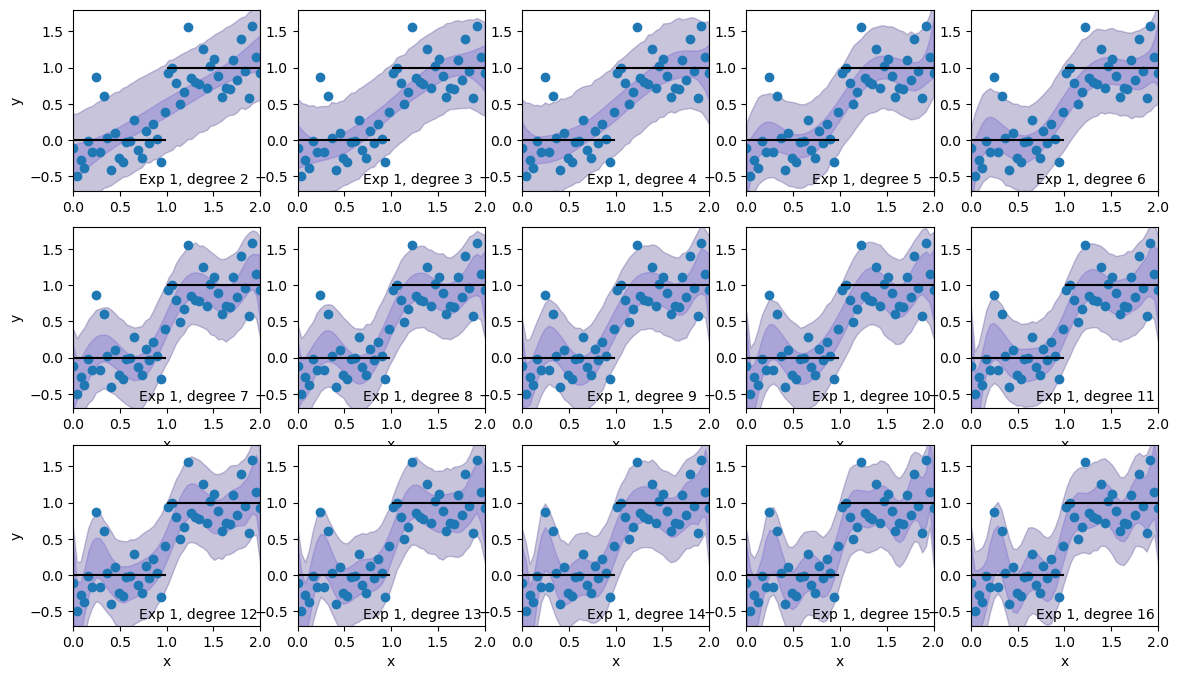

In [8]:
fig, axs = plt.subplots(3, 5, figsize=(14, 8)); axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.plot(x, y, 'o', label="observed data");

    ax.plot(x[:25], f[:25], color='k')
    ax.plot(x[25:], f[25:], color='k')
   
    name = f"Exp 1, degree {i + 2}"
    idata = idata_results1[name]
    yhat = az.extract(idata.posterior_predictive, var_names="y").data
    lower = np.percentile(yhat, 5, axis=1)
    upper = np.percentile(yhat, 95, axis=1)
    ax.fill_between(x, lower, upper, alpha=0.3, color="darkslateblue");
    
    mu = az.extract(idata.posterior, var_names="mu").data
    lower = np.percentile(mu, 5, axis=1)
    upper = np.percentile(mu, 95, axis=1)
    ax.fill_between(x, lower, upper, alpha=0.3, color="slateblue");
    
    ax.set_xlim([0, 2]);
    if i > 4:
        ax.set_xlabel("x");
    if i in [0, 5, 10]:
        ax.set_ylabel("y");
        
    ax.text(0.7, -0.6, name);
    ax.set_ylim([-0.7, 1.8])

We can see that Degree 2 clearly underfits.  The Degree 3 and Degree 4 results look pretty similar, and maybe underfit.  Degree 15 and 16 are starting to show visible signs of overfitting.  What does LOO-CV say is the best?  

We'll plot the ELPD scores and their standard errors as a function of polynomial degree.  We get some warnings about the Pareto shape being greater than 0.7 that we'll ignore for now, since it's a bit off topic (to get an accurate LOO-CV score we really should refit the model to estimate the ELPD when leaving out these high leverage points).

In [9]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

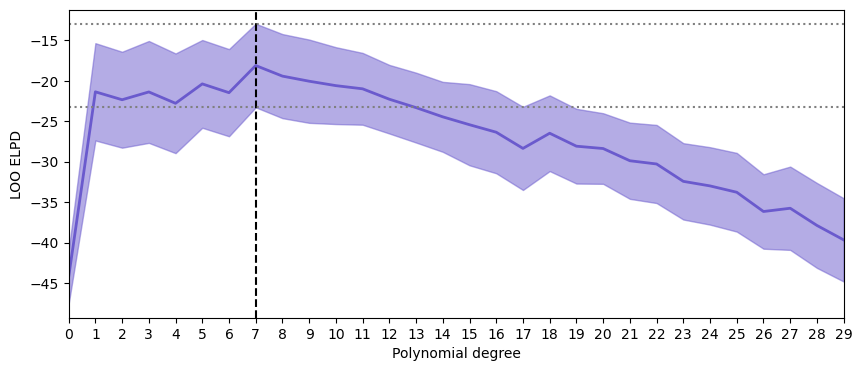

In [10]:
elpds, elpd_ses = [], []

for degree in range(len(idata_results1)):
    name = f"Exp 1, degree {degree}"
    elpd_data = az.loo(idata_results1[name])
    elpd, elpd_se = elpd_data.elpd_loo, elpd_data.se
    elpds.append(elpd)
    elpd_ses.append(elpd_se)

elpds = np.array(elpds)
elpd_ses = np.array(elpd_ses)

plt.figure(figsize=(10, 4));
plt.fill_between(np.arange(len(elpds)), elpds - elpd_ses, elpds + elpd_ses, alpha=0.5, color="slateblue")
plt.plot(np.arange(len(elpds)), elpds, color="slateblue", lw=2);
best_model_ix = np.argmax(elpds)
plt.axvline(x=best_model_ix, color="k", linestyle="--");

for degree in range(len(idata_results1)):
    name = f"Exp 1, degree {degree}"
    if degree == best_model_ix:
        lower = elpds[degree] - elpd_ses[degree]
        upper = elpds[degree] + elpd_ses[degree]
        plt.axhline(lower, color="gray", linestyle=":");
        plt.axhline(upper, color="gray", linestyle=":");

plt.xlabel("Polynomial degree");
plt.ylabel("LOO ELPD");
plt.xlim([0, len(idata_results1) - 1]);
plt.xticks(np.arange(len(idata_results1)));

Model selection gives a fit with a 7th degree polynomial as the best model.  Looking at the plot of all the fits -- sure, why not?  The standard errors are helpful here.  Their width aligns pretty well what what I'm seeing by eye in the fits, marked by the gray dotted lines.  Models from say, degree 1 though 14 are all pretty reasonable in terms of the standard error.  Past that though, the drop off is steep and it looks like overfitting becomes a serious problem.  Overall the model with the 7th degree polynomial is the winner.

# Experiment 2: Scaling the prior

The models in experiment 2 are just like those in experiment 1, except that we'll try to encode into our prior the idea that 

> “Extraordinary claims require extraordinary evidence.” (Carl Sagan)

Or more directly, Laplace's principle,

> "the weight of the evidence for an extraordinary claim must be proportional to its strangeness."

For the models in experiment 1, we put a normal prior on every `beta` coefficient that had the same standard deviation of 5.  The difference between models was only the number of polynomial basis vectors.  This prior actually means that we think that high order, complex, polynomial model is equally likely as a simple model.  Is that really what we think?  

For the models in experiment 2, we're going to downweight the scales of the priors on successive coefficients. Now it's *possible* for the model to use really high order polynomials in the fit, but it's going to need more evidence from the data to do so.  We'll see that this goes a step past preventing overfitting, to something more like automatic model selection.

A plot of the new coefficient scales is shown below.  The prior scale from experiment one is a horizontal line at 5, the same as we increase the polynomial degree.  For the models in experiment 2 we have the prior scale decay starting at 5, and approaching but never reaching zero as the degree gets large.  The plot shows the square root of the scale, so the prior variance.

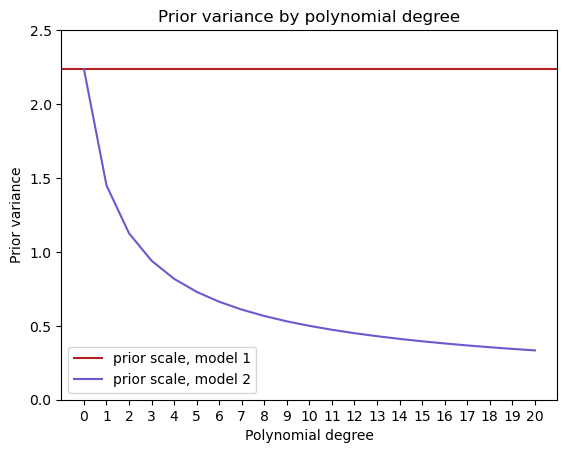

In [11]:
gamma = 1.25
degree = 20
scale = np.sqrt(5.0 * np.arange(1, degree + 2) ** (-gamma))

plt.axhline(y=np.sqrt(5.0), label="prior scale, model 1", color="firebrick")
plt.plot(np.arange(degree + 1), scale, label="prior scale, model 2", color="slateblue");
plt.ylim([0.0, 2.5]);
plt.legend();
plt.xticks(np.arange(degree + 1));
plt.title("Prior variance by polynomial degree");
plt.xlabel("Polynomial degree");
plt.ylabel("Prior variance");

Here's the model using the new scale.  Notice that we've picked a particular value of `gamma = 1.25` to make this work.  We'll see why we picked this value later.

In [12]:
@pymc_model
def ortho_poly_scaled(x, y, degree):
    Z, _, _ = ortho_poly_fit(x, degree=degree)
   
    gamma = 1.25
    scale = 5.0 * np.arange(1, degree + 2) ** (-gamma)
    beta = pm.Normal("beta", mu=0.0, sigma=scale, size=degree + 1)
   
    mu = pm.Deterministic("mu", Z @ beta)
    sigma = pm.Exponential("sigma", scale=5.0)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

Now lets run the same experiment as before, increasing the degree of the polynomial by one each time and seeing what that does the the LOO-ELPD score.

In [13]:
%%time

idata_results2 = {}
for degree in range(30):
    model = ortho_poly_scaled(x, y, degree)
    
    with model:
        idata = pm.sample(nuts_sampler="nutpie", progressbar=False)
        pm.sample_posterior_predictive(idata, progressbar=False, extend_inferencedata=True)
        pm.compute_log_likelihood(idata, progressbar=False)
        
    idata_results2[f"Exp 2, degree {degree}"] = idata

CPU times: user 3min 4s, sys: 6.21 s, total: 3min 10s
Wall time: 3min 5s


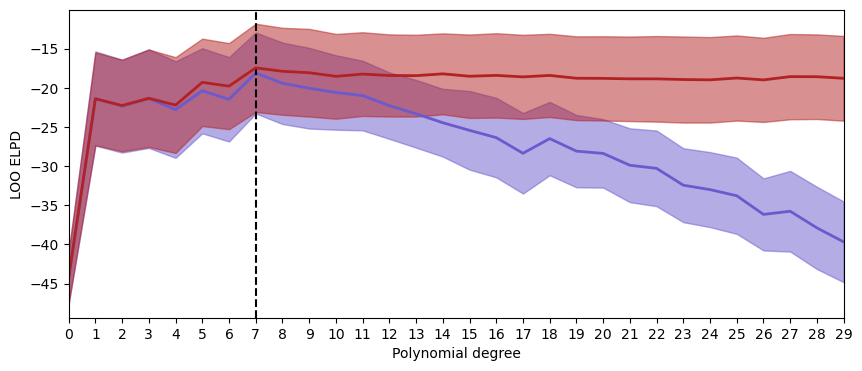

In [14]:
plt.figure(figsize=(10, 4));

elpds, elpd_ses = [], []
for degree in range(len(idata_results1)):
    name = f"Exp 1, degree {degree}"
    elpd_data = az.loo(idata_results1[name])
    elpd, elpd_se = elpd_data.elpd_loo, elpd_data.se
    elpds.append(elpd)
    elpd_ses.append(elpd_se)

elpds = np.array(elpds)
elpd_ses = np.array(elpd_ses)

plt.fill_between(np.arange(len(elpds)), elpds - elpd_ses, elpds + elpd_ses, alpha=0.5, color="slateblue")
plt.plot(np.arange(len(elpds)), elpds, color="slateblue", lw=2);
best_model_ix = np.argmax(elpds)
plt.axvline(x=best_model_ix, color="k", linestyle="--");

elpds, elpd_ses = [], []
for degree in range(len(idata_results2)):
    name = f"Exp 2, degree {degree}"
    elpd_data = az.loo(idata_results2[name])
    elpd, elpd_se = elpd_data.elpd_loo, elpd_data.se
    elpds.append(elpd)
    elpd_ses.append(elpd_se)

elpds = np.array(elpds)
elpd_ses = np.array(elpd_ses)

plt.fill_between(np.arange(len(elpds)), elpds - elpd_ses, elpds + elpd_ses, alpha=0.5, color="firebrick")
plt.plot(np.arange(len(elpds)), elpds, color="firebrick", lw=2);

plt.xlabel("Polynomial degree");
plt.ylabel("LOO ELPD");
plt.xlim([0, len(idata_results1) - 1]);
plt.xticks(np.arange(len(idata_results1)));

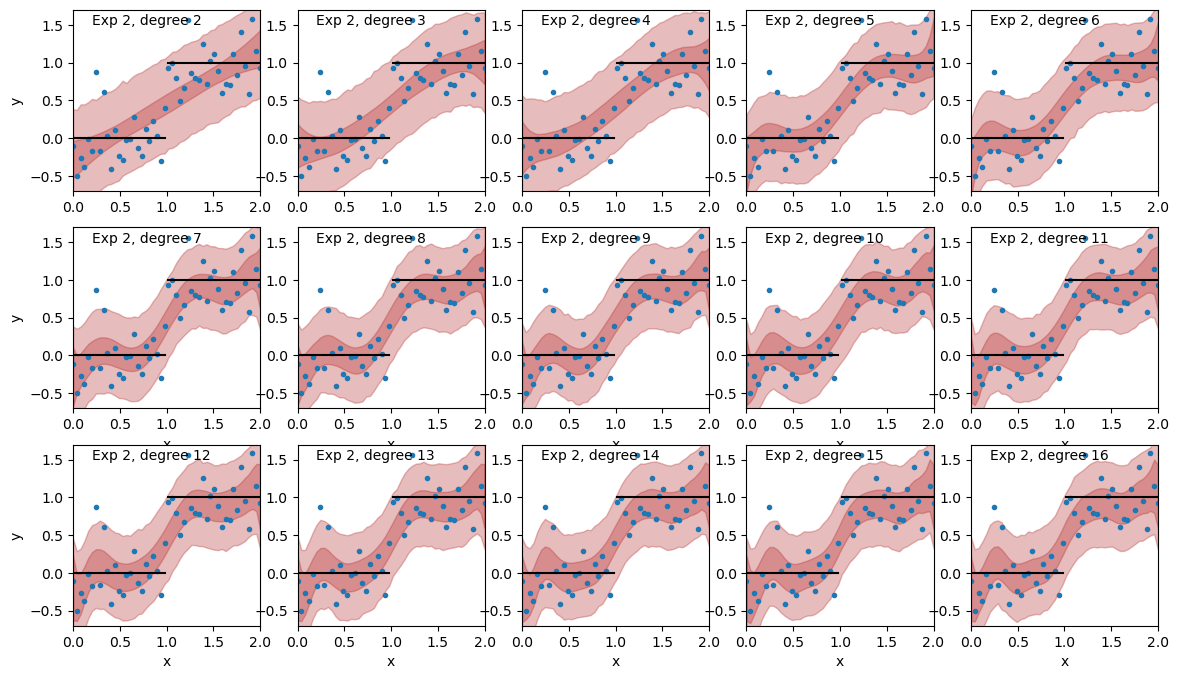

In [15]:
fig, axs = plt.subplots(3, 5, figsize=(14, 8)); axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.plot(x, y, '.', label="observed data");

    ax.plot(x[:25], f[:25], color='k')
    ax.plot(x[25:], f[25:], color='k')
   
    name = f"Exp 2, degree {i + 2}"
    idata = idata_results2[name]
    yhat = az.extract(idata.posterior_predictive, var_names="y").data
    lower = np.percentile(yhat, 5, axis=1)
    upper = np.percentile(yhat, 95, axis=1)
    ax.fill_between(x, lower, upper, alpha=0.3, color="firebrick");
    
    mu = az.extract(idata.posterior, var_names="mu").data
    lower = np.percentile(mu, 5, axis=1)
    upper = np.percentile(mu, 95, axis=1)
    ax.fill_between(x, lower, upper, alpha=0.3, color="firebrick");
    
    ax.set_xlim([0, 2]);
    if i > 4:
        ax.set_xlabel("x");
    if i in [0, 5, 10]:
        ax.set_ylabel("y");
        
    ax.text(0.2, 1.5, name);
    ax.set_ylim([-0.7, 1.7])

The fit from Degree 7 and on are all essentially indistinguishable now.  

# Bonus points

What about `gamma`, how did we choose that?  The [Occam's razor paper also talks about this](https://mlg.eng.cam.ac.uk/zoubin/papers/occam.pdf) (at the start of Sec. 3).  This time we'll just run it once as a 30 degree polynomial (which is only 5 less than the total number of data points!).  We should get the same ELPD.  Yes, this is how I chose the magic number `gamma = 1.25` above.   

In [16]:
with pm.Model() as model:
    degree = 30
    Z, _, _ = ortho_poly_fit(x, degree=degree)
   
    gamma = pm.Exponential("gamma", scale=1.0)
    scale = 5.0 * np.arange(1, degree + 2) ** (-gamma)
    beta = pm.Normal("beta", mu=0.0, sigma=scale, size=degree + 1)
   
    mu = pm.Deterministic("mu", Z @ beta)
    sigma = pm.Exponential("sigma", scale=5.0)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)
        
    idata = pm.sample(nuts_sampler="nutpie", target_accept=0.9)
    pm.sample_posterior_predictive(idata, progressbar=False, extend_inferencedata=True)
    pm.compute_log_likelihood(idata, progressbar=False)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.21,15
,2000,0,0.35,31
,2000,0,0.37,7
,2000,0,0.37,7


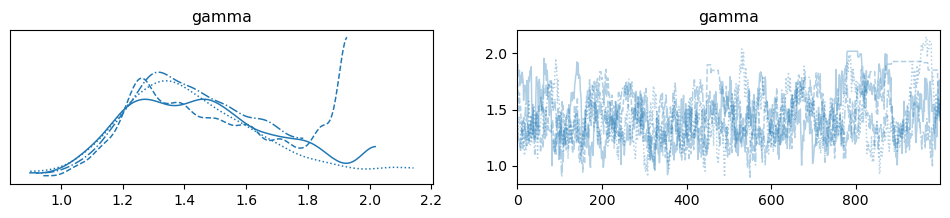

In [17]:
az.plot_trace(idata, var_names="gamma");

In [18]:
elpd_data = az.loo(idata)
print(f"ELPD: {elpd_data.elpd_loo:0.2f}, ELPD SE: {elpd_data.se:0.2f}")

ELPD: -19.55, ELPD SE: 5.65


In [19]:
all_idatas = {**idata_results1, **idata_results2, **{"Prior on gamma": idata}}

In [20]:
warnings.simplefilter("ignore", category=FutureWarning)
az.compare(all_idatas).head(10)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
"Exp 2, degree 7",0,-17.454417,6.941462,0.000000,8.843849e-01,5.637879,0.000000,True,log
"Exp 2, degree 8",1,-17.889721,7.308506,0.435304,8.432485e-11,5.551900,0.345881,False,log
"Exp 2, degree 9",2,-18.075383,7.693926,0.620966,8.439987e-11,5.598566,0.523907,False,log
"Exp 1, degree 7",3,-18.110580,8.180686,0.656163,9.358834e-02,5.170638,1.436110,True,log
"Exp 2, degree 14",4,-18.215979,8.552262,0.761563,8.368721e-11,5.167451,1.050139,True,log
"Exp 2, degree 11",5,-18.249420,8.155402,0.795003,8.424486e-11,5.345232,0.717376,True,log
"Exp 2, degree 16",6,-18.413651,9.180511,0.959234,8.374915e-11,5.385329,1.087181,True,log
"Exp 2, degree 18",7,-18.417945,9.394612,0.963528,8.369683e-11,5.313482,1.114191,True,log
"Exp 2, degree 12",8,-18.425259,8.428294,0.970842,8.436344e-11,5.245622,0.767023,True,log
"Exp 2, degree 13",9,-18.448142,8.545733,0.993726,8.429243e-11,5.217694,0.846622,False,log


It looks like in this case putting a prior on `gamma` isn't as good as choosing `gamma = 1.25`, however, notice that the ELPD estimates are all within the standard error of each other. 

# Summary

We've essentially transformed a discrete prior on model complexity via the choice of the number of basis vectors, to a continuous prior on model complexity, represented by the `gamma` parameter.  This example nicely demonstrates that the common example you've probably seen about model complexity and the bias variance trade-off isn't really the whole story.  

Neal argues that it's better to use a complex model where the simple model is a special case, and let the data decide.  Gaussian processes are really good at doing this.  In particular, the HSGP approximation looks almost exactly like this.   

There's also a relationship to penalized splines.  There's a nice [case study in Stan](https://mc-stan.org/users/documentation/case-studies/splines_in_stan.html) and an implementation [here in PyMC](https://gist.github.com/AustinRochford/d640a240af12f6869a7b9b592485ca15).  The same underlying concept is at play here too.  The idea is not to spend too much time choosing the number and location of knots, but instead choose "too many" knots and rely on the coefficient priors to control model complexity.  For spline coefficients, we also care about _smoothness_, in addition to how they prior penalizes their distance from zero.  Flatter functions will all have more similar spline coefficients.

I also think this same idea shows up when choosing features to include in a regression model.  I think it's too easy to get yourself wrapped around the handle of choosing regressors, turning your modeling problem into model selection problem.  This example shows that it's preferable to have a more complex model *available* to the data, but to allow the data to choose a simpler model in the absence of evidence for a more complex model.  

As a resolution for this example, it doesn't really matter if we choose the prior from experiment 1 and select 7 basis vectors, or take the prior from experiment 2 and select a larger number.  It's nice to know that in the context of more complicated models, as long as we don't have identifiability issues, the approach of experiment 2 is both easier to implement and is more likely to yield better models.  